# Calculate the expected RV semi-amplitude

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [13]:
import seaborn as sb
import astropy.units as u

from arviz.stats import kde
from scipy.stats import gaussian_kde, percentileofscore as pos
from astropy.units import R_earth, R_jup, R_sun, M_earth, M_sun
from astropy.constants import G

from spright import RMRelation

rc('figure', figsize=(13,5))

In [3]:
%run src/core.py

In [4]:
%run src/plotting.py

In [5]:
rmr = RMRelation()

In [6]:
rplanet = 1.54, 0.09

In [7]:
from spright.model import create_radius_density_icdf
from spright.analytical_model import map_pv, map_r_to_xy, mixture_weights

nsamples = 3000

rd = rmr.rdm
pvs = rmr.posterior_samples.iloc[permutation(rmr.posterior_samples.shape[0])[:nsamples]]

radii, densities, probs, rdmap, icdf = create_radius_density_icdf(pvs.values, rd, rres=300, dres=200, pres=200, separate_components=True)

In [8]:
from scipy.interpolate import RegularGridInterpolator

rgir = RegularGridInterpolator((radii, probs), icdf[0], bounds_error=False)
rgiw = RegularGridInterpolator((radii, probs), icdf[1], bounds_error=False)
rgip = RegularGridInterpolator((radii, probs), icdf[2], bounds_error=False)

In [9]:
nsamples = 20_000
pvs = rmr.posterior_samples.iloc[permutation(rmr.posterior_samples.shape[0])[:nsamples]].values
imax = pvs.shape[0]

In [11]:
from astropy import units as u

dsamples = [[],[],[]]
rsamples = [[], [], []]
msamples = []
ksamples = []

ecc = 0.0

rs = normal(rplanet[0], rplanet[1], nsamples)
for i in range(nsamples):
    _r = rs[i]
    pv = map_pv(pvs[i% imax])
    x, y = map_r_to_xy(rs[i:i+1], *pv[:4])
    cws = cumsum(mixture_weights(x, y))
    
    x = uniform()
    if x < cws[0]:
        rsamples[0].append(_r)
        dsamples[0].append(rgir((_r, uniform())))
    elif x < cws[1]:
        rsamples[1].append(_r)
        dsamples[1].append(rgiw((_r, uniform())))
    else:
        rsamples[2].append(_r)
        dsamples[2].append(rgip((_r, uniform())))

dsamples = [array(a) for a in dsamples]
rsamples = [array(a) for a in rsamples]

for rs, ds in zip(rsamples, dsamples):
    v = 4 / 3 * pi * (rs * u.R_earth).to(u.cm) ** 3
    m_g = v * ds * (u.g / u.cm ** 3)
    msamples.append(m_g.to(u.M_earth).value)

    mst = (normal(star_m.n, star_m.s, size=rs.size) * M_sun).to(u.kg)
    prd = (normal(period.n, period.s, size=rs.size) * u.d).to(u.s)
    k = ((2*pi*G/prd)**(1/3) * m_g.to(u.kg) / mst**(2/3) * (1/sqrt(1-ecc**2))).value
    ksamples.append(k)

In [18]:
def plot_dists(samples, bw, vlim=None, xlim=None, xlabel='', unit='', ax=None, add_legend=False, label_medians=False):
    colors = 'saddlebrown', 'skyblue', 'yellow'
    labels = 'Rocky', 'Water-rich', 'Sub-Neptune'
    norm = array([a.size for a in samples], dtype='d')
    norm /= norm.sum()

    if ax is None:
        fig, ax = subplots()
    else:
        fig, ax = ax.get_figure(), ax
    
    for i, s in enumerate(samples):
        ps = percentile(s, [50, 16, 84])
        m = (s>vlim[0]) & (s<vlim[1])
        x, y = kde(s[m], bw=bw, custom_lims=vlim)
        c = sb.set_hls_values(colors[i], l=0.92)
        ax.fill_between(x, y * norm[i], zorder=10+i*5, fc=c, ec='k')
        c = sb.set_hls_values(colors[i], l=0.7)
        ax.fill_between(x, where((x>ps[1])&(x<ps[2]), y * norm[i], nan), label=labels[i], zorder=10+i*5, fc=c, ec='k')

        ix = argmin(abs(x-ps[0]))
        ax.plot(x[[ix, ix]], [0, y[ix]* norm[i]], 'k--', zorder=11+i*5)
        if label_medians:
            ax.text(x[ix]-0.05, 0.5*y[ix]*norm[i], f'{x[ix]:.1f} {unit}', rotation=90, zorder=12+i*5, va='center', ha='right', size='small')

    cs = concatenate(samples)
    m = (cs>vlim[0]) & (cs<vlim[1])
    x, y = kde(cs[m], bw=bw, custom_lims=vlim)
    ps = percentile(cs, [50, 16, 84, 2.5, 97.5])
    ax.fill_between(x, y, fc='0.75', ec='k', zorder=0, lw=1)
    ax.plot(x, y, 'k', lw=2, zorder=100)
    ax.axvline(ps[0], zorder=-10, c='k')
    #[ax.axvline(p, zorder=0, c='k') for p in ps]
    c = sb.set_hls_values('steelblue', l=0.8)
    ax.axvspan(ps[1], ps[2], zorder=-2, fc=c)
    c = sb.set_hls_values('steelblue', l=0.9)
    ax.axvspan(ps[3], ps[4], zorder=-3, fc=c)
    #ax.axhline(0, zorder=200, c='k', lw=2)

    if add_legend:
        ax.legend(loc='upper left', fontsize='small')
    setp(ax, xlim=xlim, ylim=(0.0, 1.075*y.max()), xlabel=f'{xlabel} [{unit}]', yticks=[], ylabel='Probability density')


In [23]:
percentile(concatenate(ksamples), [2.5, 97.5])

array([1.93875105, 8.32175695])

In [35]:
for s in ksamples:
    ps = percentile(s, [50, 16, 84])
    print(f"{ps[0]:.1f} {abs(ps[1:]-ps[0]).mean():.1f}")

5.4 1.3
2.8 0.8
3.3 0.7


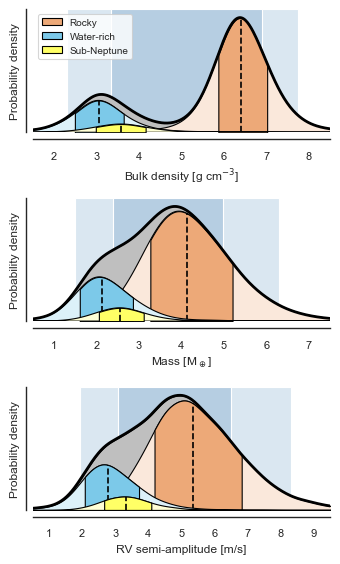

In [20]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(3, 1, figsize=(AACW, 1.65*AACW))
    plot_dists(dsamples, 0.3, vlim=(0,12), xlim=(1.5, 8.5), xlabel='Bulk density', unit='g cm$^{-3}$', ax=axs[0], add_legend=True)
    plot_dists(msamples, 0.3, vlim=(0,10), xlim=(0.5, 7.5), xlabel='Mass', unit='M$_\oplus$', ax=axs[1])
    plot_dists(ksamples, 0.3, vlim=(0,10), xlim=(0.5, 9.5), xlabel='RV semi-amplitude', unit='m/s', ax=axs[2])
    setp(axs[0], xticks=arange(2,9))
    setp(axs[1], xticks=arange(1,8))
    setp(axs[2], xticks=arange(1,10))
    sb.despine(offset=5)
    fig.tight_layout()
    fig.savefig('plots/TOI_2266b_rv_semiamplitude_paper.pdf')

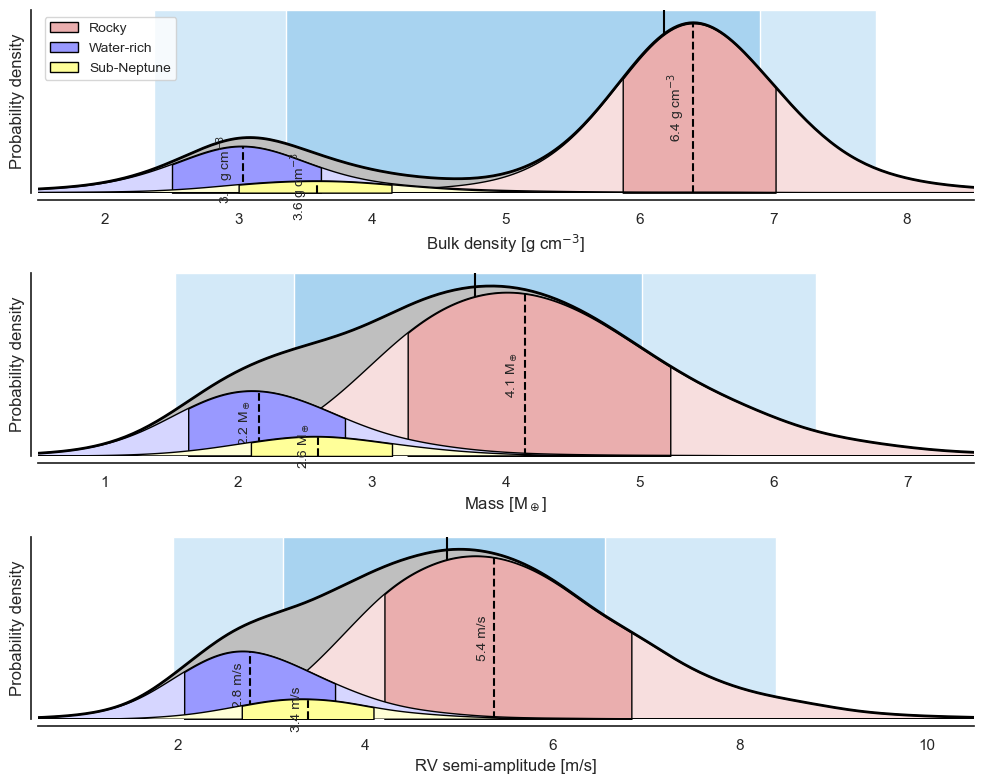

In [262]:
fig, axs = subplots(3, 1, figsize=(10,8))
plot_dists(dsamples, 0.3, vlim=(0,15), xlim=(1.5, 8.5), xlabel='Bulk density', unit='g cm$^{-3}$', ax=axs[0], add_legend=True)
plot_dists(msamples, 0.3, vlim=(0,15), xlim=(0.5, 7.5), xlabel='Mass', unit='M$_\oplus$', ax=axs[1])
plot_dists(ksamples, 0.3, vlim=(0,15), xlim=(0.5, 10.5), xlabel='RV semi-amplitude', unit='m/s', ax=axs[2])
sb.despine(offset=5)
fig.tight_layout()

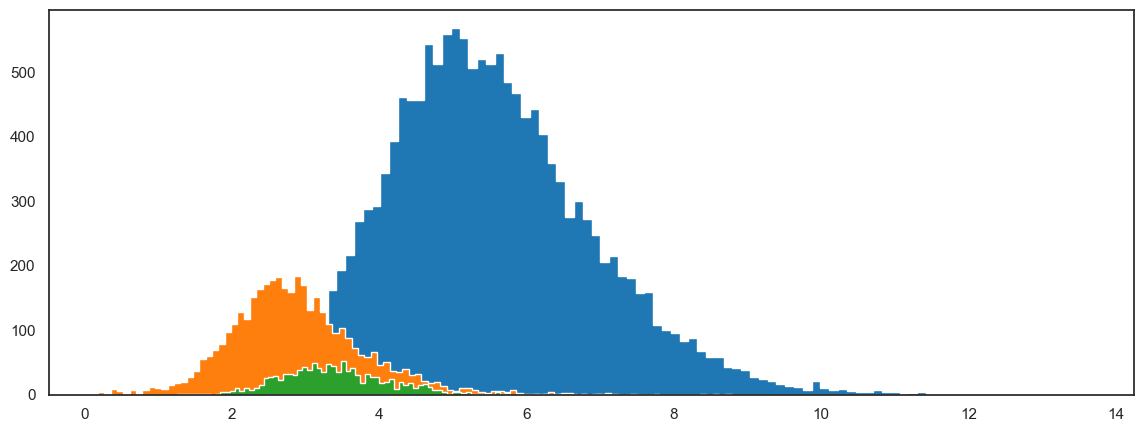

In [70]:
hist(ksamples[0], bins=100, density=False, histtype='stepfilled');
hist(ksamples[1], bins=100, density=False, histtype='stepfilled');
hist(ksamples[2], bins=100, density=False, histtype='stepfilled');

In [14]:
mass_distribution = rmr.sample('mass', (1.54, 0.09), 50_000)

In [15]:
density_distribution = rmr.sample('density', (1.54, 0.09), 50_000)

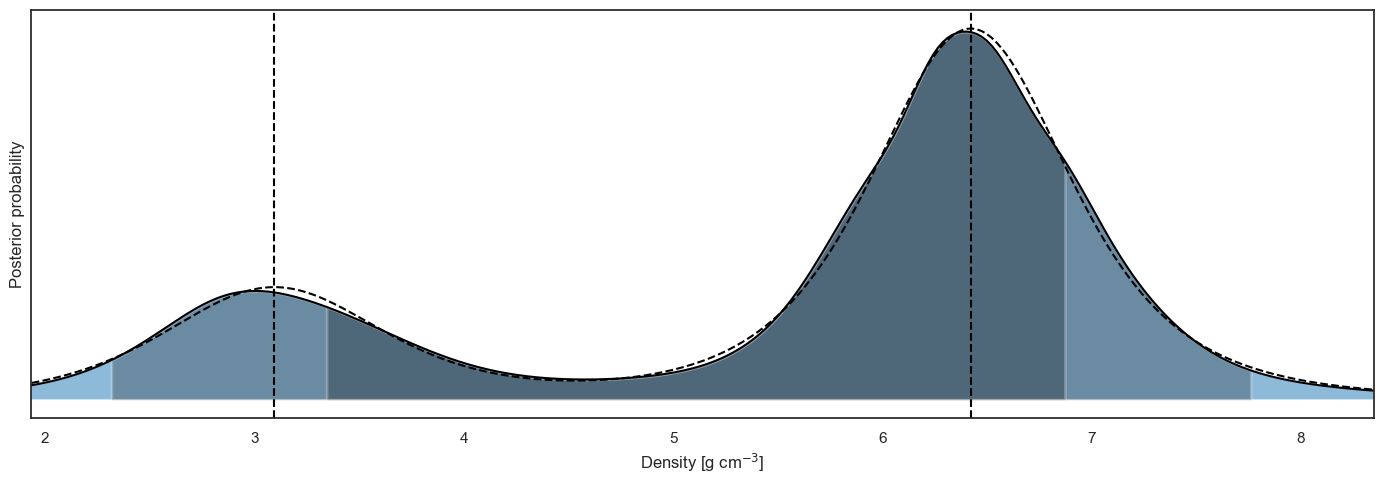

In [16]:
density_distribution.plot()

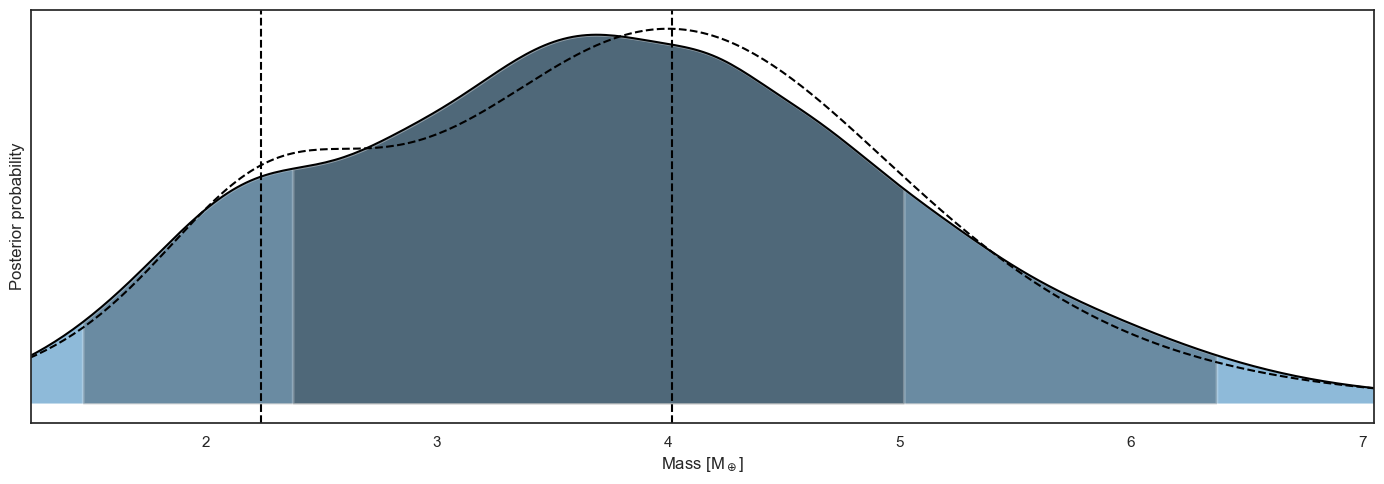

In [17]:
mass_distribution.plot()

In [18]:
ns = mass_distribution.size

mstar = normal(star_m.n, star_m.s, ns)
mplanet = mass_distribution.samples
pr = normal(period.n, period.s, ns)

In [19]:
star_m

0.228+/-0.023

In [20]:
period

2.326214+/-0.000223

In [21]:
k = (2*pi*G / (pr * u.d).to(u.s))**(1/3) * (mplanet * M_earth).to(u.kg) / (mstar * M_sun).to(u.kg)**(2/3)

In [22]:
percentile(k, [2.5, 97.5])

<Quantity [1.89299571, 8.46186243] m / s>

In [23]:
percentile(k, [2.5, 97.5])

<Quantity [1.89299571, 8.46186243] m / s>

In [24]:
plims = 50 - 68/2, 50 + 68/2, 50 - 95/2, 50 + 95/2, 50 - 99.7/2, 50 + 99.7/2

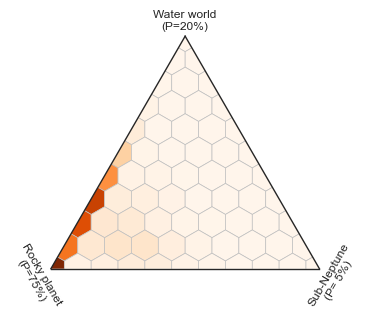

In [38]:
with sb.plotting_context('paper', font_scale=0.9):
    ax = rmr.plot_class((1.54, 0.09), figsize=(AAOCW, AAOCW))
    ax.get_figure().savefig('plots/TOI-2266b_class.pdf')

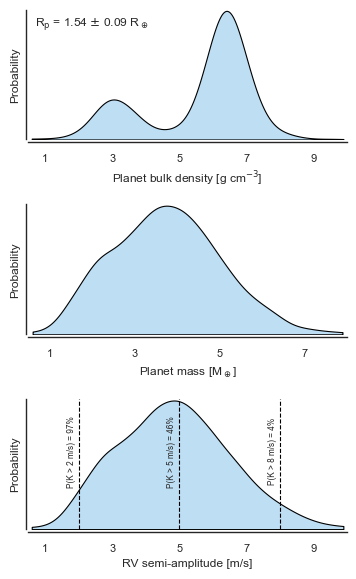

In [31]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(3, 1, figsize=(AACW, 1.65*AACW))
    c = sb.set_hls_values('C0', l=0.85)
    
    ax = axs[0]
    kde = gaussian_kde(density_distribution.samples, bw_method=0.2)
    x = linspace(0.6, 9.9, 500)
    y = kde(x)
    ax.fill_between(x, y, fc=c, ec='k')
    ax.text(0.02, 0.95, 'R$_\mathrm{p}$ = 1.54 $\pm$ 0.09 R$_\oplus$', va='top', transform=ax.transAxes)
    setp(axs[0], xlabel='Planet bulk density [g cm$^{-3}$]', ylabel='Probability', yticks=[], ylim=(0, 1.01*y.max()), 
         xlim=(0.5, 10), xticks=[1,3,5,7,9])
    
    ax = axs[1]
    kde = gaussian_kde(mass_distribution.samples, bw_method=0.2)
    x = linspace(0.6, 7.9, 500)
    y = kde(x)
    ax.fill_between(x, y, fc=c, ec='k')
    setp(axs[1], xlabel='Planet mass [M$_\oplus$]', ylabel='Probability', yticks=[], ylim=(0, 1.01*y.max()), 
         xlim=(0.5, 8), xticks=[1,3,5,7])

    ax = axs[2]
    kde = gaussian_kde(k, bw_method=0.2)
    x = linspace(0.6, 9.9, 500)
    y = kde(x)
    ax.fill_between(x, y, fc=c, ec='k')

    for p in (2, 5, 8):
        axvline(p, c='k', lw=0.8, ls='--')
        ax.text(p-0.35, 0.14, f'P(K > {p} m/s) = {100 - pos(k, p):.0f}%', size='x-small', rotation=90, va='center')

    setp(axs[2], xlabel='RV semi-amplitude [m/s]', ylabel='Probability', yticks=[], xticks=[1,3,5,7,9], 
         xlim=(0.5, 10), ylim=(0, 1.01*y.max()))
    
    #for ax,lb in zip(axs, 'a. b. c.'.split()):
    #    ax.text(0.02, 0.98, lb, va='top', transform=ax.transAxes)
    
    sb.despine(fig, offset=2)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.08, left=0.07, right=0.99, top=0.99, hspace=0.5)
    fig.savefig('plots/TOI_2266b_rv_semiamplitude_paper.pdf')